In [3]:
import os
import time
from pathlib import Path

def findAllFiles(path):
    res = []
    path, folders, files = next(os.walk(path))
    if folders:
        for f in folders:
            res.extend(findAllFiles(os.path.join(path, f)))
    res.extend([os.path.join(path, f) for f in files if not f.endswith(".txt")])
    return res

ds_name = "imagenette2-320"
ds_path = Path("/home/gustav/Downloads/") / ds_name
ds_cats = ["train", "val"]

res_dir = Path("/home/gustav/Downloads/ds_proc/")

os.makedirs(res_dir, exist_ok=True)

In [10]:
%%time

import os
import dng
import cfa
import noise
import numpy as np
from PIL import Image


def add_noise_to_ds_category(ds_path, res_dir, suffix, noise, noise_amt, size):
    noise_type, noise_func = noise
    save_path_png          = res_dir / "png" / noise_type / f"{noise_amt*100:g}pct" / suffix
    save_path_dng          = res_dir / "dng" / noise_type / f"{noise_amt*100:g}pct" / suffix
    save_path_npy          = res_dir / "npy" / noise_type / f"{noise_amt*100:g}pct" / suffix
    os.makedirs(save_path_png, exist_ok=True)
    os.makedirs(save_path_dng, exist_ok=True)
    os.makedirs(save_path_npy, exist_ok=True)
    
    imgs = findAllFiles(ds_path / suffix)[:10]
    
    
    for n, img in enumerate(imgs):
        img_rgb       = np.array(Image.open(img).convert("RGB"), dtype=np.uint8)
        
        # Center crop
        h, w, c = img_rgb.shape
        offset_x = (h - size) // 2
        offset_y = (w - size) // 2
        
        img_crop      = np.zeros((size,size,c))
        img_crop      = img_rgb[offset_x:(offset_x+size), offset_y:(offset_y+size)]
        img_rgb_noise = noise_func(img_crop, amount=noise_amt)
        
        # Save Noisy RGB image
        Image.fromarray(img_rgb_noise).save(save_path_png / f"{n}.png", format="PNG")
        
        img_cfa = cfa.rgb_to_cfa(img_rgb_noise.astype(np.uint16) * 2**8, cfa.rgb_kf)   

        # Save noisy CFA
        dng.write(img_cfa, filename=str(save_path_dng / str(n)))
        np.save(save_path_npy / str(n), img_cfa)


def add_noise_to_ds(ds_path, res_dir, suffixes, noises, noise_amts, size):
    for noise in noises:
        for noise_amt in noise_amts:
            for suffix in suffixes:
                add_noise_to_ds_category(ds_path, res_dir, suffix, noise, noise_amt, size)

noises = [
    ("gaussian",   noise.gaussian_noise),
    ("speckle",    noise.norm_speckle_noise),
    ("saltpepper", noise.salt_pepper_noise)
]

noise_amts = [0.1, 0.3, 0.7]
suffixes   = ["train", "val"]
size = 320

add_noise_to_ds(ds_path, res_dir, suffixes, noises, noise_amts, size)

CPU times: user 7.16 s, sys: 342 ms, total: 7.5 s
Wall time: 7.51 s


In [15]:
%%time

from itertools import product
from multiprocessing import Pool, cpu_count

def f(args):
    noise, noise_amt, suffix = args
    add_noise_to_ds_category(ds_path, res_dir, suffix, noise, noise_amt, size)

def p_add_noise_to_ds(ds_path, res_dir, suffixes, noises, noise_amts, size):
    args = list(product(noises, noise_amts, suffixes))

    p = Pool(processes=cpu_count())
    p.map(f, args)

noises = [
    ("gaussian",   noise.gaussian_noise),
    ("speckle",    noise.norm_speckle_noise),
    ("saltpepper", noise.salt_pepper_noise)
]

noise_amts = [0.1, 0.3, 0.7]
suffixes   = ["train", "val"]
size = 320

p_add_noise_to_ds(ds_path, res_dir, suffixes, noises, noise_amts, size), cpu_count()

CPU times: user 60 ms, sys: 88.9 ms, total: 149 ms
Wall time: 2.4 s


(None, 8)

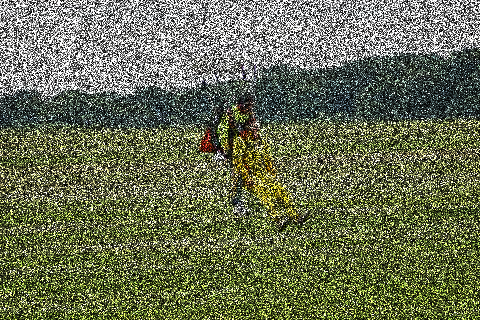

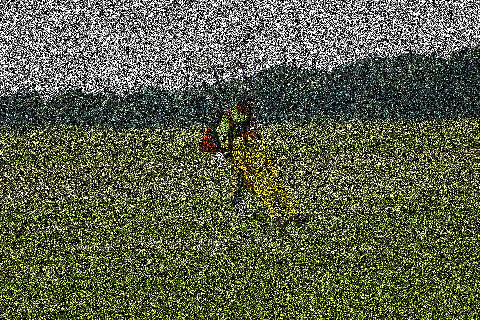

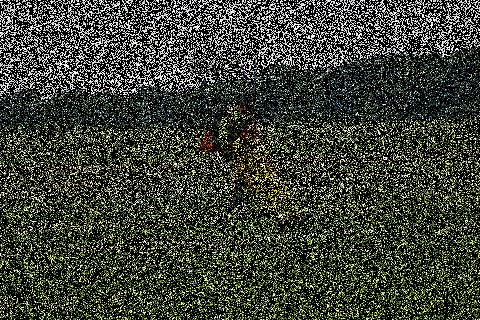

In [23]:
import noise
import importlib

img     = findAllFiles(ds_path / "train")[0]
img_rgb = np.array(Image.open(img).convert("RGB"), dtype=np.uint8)

def norm_speckle_noise(img, amount=.3):
    h, w, c = img.shape
    d_max   = np.iinfo(img.dtype).max

    gen     = np.random.default_rng()
    noise   = np.expand_dims(gen.normal(0, amount, (h, w)), 2)

    res     = img.astype(np.int64) + (img.astype(np.int64) * noise)

    return np.clip(res, 0, d_max).astype(img.dtype)

importlib.reload(noise)

display(Image.fromarray(noise.exp_speckle_noise(img_rgb, 0.00001)))
display(Image.fromarray(noise.exp_speckle_noise(img_rgb, 0.3)))
display(Image.fromarray(noise.exp_speckle_noise(img_rgb, 0.9)))


In [10]:
/archive/index.html%%time

import dng
import cfa
import numpy as np
from PIL import Image


suffix         = "train"
save_path      = ds_path + "dng/"
imgs           = findAllFiles(ds_path + suffix)[:10000]
cell_x, cell_y = (64,64)
pad_x, pad_y   = ((226 - 64) // 2, (226 - 64) // 2)

for n, img in enumerate(imgs):
    img     = Image.open(img).convert("RGB")
    img_arr = cfa.rgb_to_cfa(np.array(img, dtype=np.uint16) * 2**8, cfa.rgb_kf)
    
    res = np.zeros((pad_x*2 + cell_x, pad_y*2 + cell_y), dtype=np.uint16)
    res[pad_x:pad_x+cell_x, pad_y:pad_y+cell_y] = img_arr
    
    dng.write(img_arr, filename=f"{save_path}{suffix}_{n}")

CPU times: user 3.37 s, sys: 477 ms, total: 3.85 s
Wall time: 4.59 s


In [42]:
f"{0.3*100:g}pct"

'30pct'